In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from __future__ import division, print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, Input, Reshape, Lambda, Concatenate, Subtract, Reshape, multiply
from keras.layers import Embedding, ZeroPadding2D
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras import backend as K
from keras.optimizers import Nadam, Adam, SGD
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.callbacks import Callback, History
import tensorflow as tf
import pandas as pd
import glob
import PIL
from sys import getsizeof
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import MaxNLocator
from sklearn.utils import class_weight
from keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Image shape information
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]

if len(X_train.shape) == 4:
    channels = X_train.shape[3]
else:
    channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
def generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

In [5]:
def discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)

In [6]:
discriminator = discriminator()

discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = generator()

# The generator takes noise and the target label as input
# and generates the corresponding digit of that label

noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
# and the label of that image
valid = discriminator([img, label])

# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator

combined = Model([noise, label], valid)
combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0

In [7]:
print(img.shape.as_list())

[None, 28, 28, 1]


In [8]:
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)
    for i in range(0, len(sampled_labels)):    
        print(sampled_labels[i]) 
    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    """
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    """
    cnt = 0
    for i in range(2 * 5):
      plt.axis('off')
      plt.imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      cnt += 1
      filename = "/content/%d" % sampled_labels[cnt-1]

      if not os.path.exists(filename):
          os.makedirs(filename)
      plt.savefig("/content/%d/%d.png" % ( sampled_labels[cnt-1], epoch))
    
    plt.close()

In [9]:
epochs=5000
batch_size=32
sample_interval=50

In [10]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

y_train = y_train.reshape(-1, 1)

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))    

# Declaring empty lists to save the losses for plotting
d_loss_plot = []
g_loss_plot = []
acc_plot = []

1/1 [==============================] - 0s 495ms/step
0/5000 [D loss: 0.696629, acc.: 17.19%] [G loss: 0.681853]
1/1 [==============================] - 0s 139ms/step


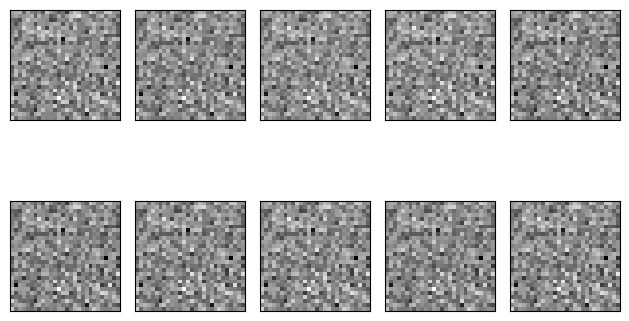

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 42ms/step
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 27ms/step
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 26ms/step
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 68ms/step
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 24ms/step
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 37ms/step
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 24ms/step


In [ ]:
for epoch in range(epochs):
    #Training the Discriminator
    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict([noise, labels])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #Training the Generator
    # Condition on labels
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], valid)

    # Saving the Discriminator and Generator losses and accuracy for plotting
    d_loss_plot.append(d_loss[0])
    g_loss_plot.append(g_loss)
    acc_plot.append(d_loss[1])

    # Plot the progress every 100 epochs
    if epoch % 500 == 0:
        print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)  
        x_fake = generator.predict([z, labels])
        cnt=0
        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            #plt.axes.axes.set_title("Digit: %d" % sampled_labels[cnt])
            plt.xticks([])
            plt.yticks([])
            cnt+=1
        plt.tight_layout()
        plt.show()

    # Saving generated image samples at every sample interval
    if epoch % sample_interval == 0:
        sample_images(epoch)

In [ ]:
plt.plot(acc_plot)

plt.title('Discriminator accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.show()



# Loss plots

plt.plot(d_loss_plot)

plt.plot(g_loss_plot)

plt.title('Losses')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['Discriminator', 'Generator'])

plt.show()

In [ ]:
import zipfile
! zip -r /content/content.zip /content/


In [ ]:
from google.colab import drive
import shutil
import zipfile

drive.mount("/content/drive")


with zipfile.ZipFile('/content/content.zip', 'r') as zip:
    zip.extractall('/content')
shutil.rmtree('/content/content/drive',  ignore_errors=True)
shutil.rmtree('/content/content/sample_data',  ignore_errors=True)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.utils import load_img
from PIL import Image
import os

path_to_files = "/content"
vectorized_images_x = []
vectorized_images_Y = []

#for _, file_num in enumerate(os.listdir(path_to_files)):
for folnum in range(10):
  filename = "/content/%s" % folnum
  print(filename)
  for _, file in enumerate(os.listdir(filename)):
    path = "%s/%s" % (filename,file)
    print(path)
    img = load_img(path,target_size=(28,28))
    plt.imshow(img,interpolation='nearest',cmap='gray')
    #plt.show()
    img1 = rgb_to_grayscale(
    img, name=None)
    img_array = np.expand_dims(np.array(img1), axis=2)
    img_array.shape
    img_array=img_array.reshape(28,28,1)
    img_array.shape
    vectorized_images_x.append(img_array)    
    vectorized_images_Y.append(int(folnum))

np.savez("./mnistlikedataset.npz",DataX=vectorized_images_x,DataY=vectorized_images_Y)